In [31]:
!pip install datascience

In [ ]:
from datascience import *
#path_data = '../../../assets/data/'
path_data = 'data/'
import numpy as np

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# A/B Testing
현대 데이터 분석에서 두 개의 수치 표본이 동일한 기저 분포에서 나온 것인지 판단하는 것을 *A/B 검정*이라고 합니다. 이 이름은 두 표본의 라벨 A와 B에서 유래했습니다.

예제를 통해 이 방법을 개발하겠습니다. 데이터는 대형 병원 시스템의 신생아 표본에서 나온 것입니다. 표본추출이 여러 단계로 이루어졌지만, 단순 무작위 표본으로 간주하겠습니다. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this set is drawn.

## 흡연자와 비흡연자
표 `births`에는 1,174쌍의 엄마-아기 쌍에 대한 다음 변수가 포함되어 있습니다: 아기의 출생 체중(온스), 임신 일수, 엄마의 완성된 나이, 엄마의 키(인치), 임신 체중(파운드), 그리고 엄마가 임신 중에 흡연했는지 여부입니다.

In [ ]:
births = Table.read_table(path_data+'baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


이 연구의 목표 중 하나는 산모의 흡연이 출생 체중과 연관되어 있는지 확인하는 것이었습니다. 두 변수에 대해 무엇을 말할 수 있는지 살펴보겠습니다.

`Birth Weight`와 `Maternal Smoker`만 선택하여 시작하겠습니다. 표본의 여성 중 715명이 비흡연자이고 459명이 흡연자입니다.

In [ ]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [ ]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


비흡연 산모의 아기들의 출생 체중 분포를 흡연 산모의 아기들과 비교해 보겠습니다. 두 개의 겹쳐진 히스토그램을 생성하기 위해 열 라벨이나 인덱스인 선택적 `group` 인수와 함께 `hist`를 사용할 것입니다. 테이블의 행들이 먼저 이 열로 그룹화되고 각각에 대해 히스토그램이 그려집니다.

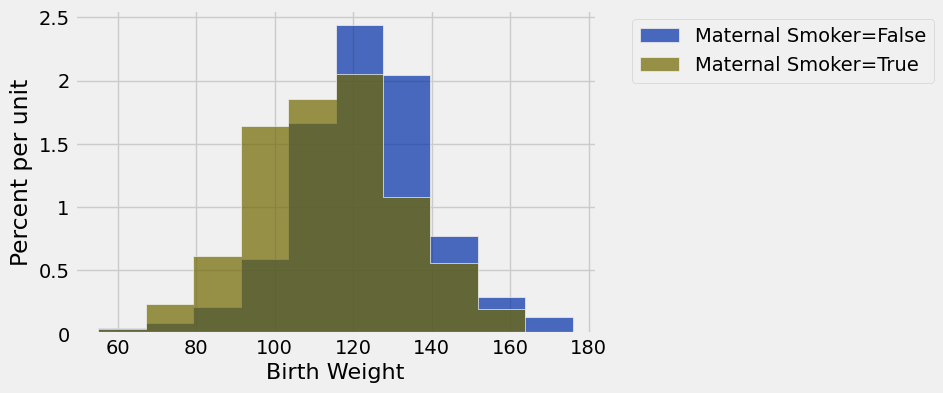

In [ ]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')

흡연한 산모에게서 태어난 아기들의 체중 분포는 비흡연 산모에 해당하는 분포보다 약간 왼쪽으로 치우쳐 있는 것으로 보입니다. 흡연한 산모의 아기들의 체중이 비흡연자의 아기들의 체중보다 평균적으로 더 낮은 것으로 보입니다.

이는 그 차이가 단순히 우연한 변동을 반영하는 것인지, 아니면 더 큰 모집단의 분포 차이를 반영하는 것인지에 대한 질문을 제기합니다. 모집단에서는 두 분포 사이에 차이가 없지만, 우연히 선택된 산모들 때문에 표본에서 차이를 보는 것일 수 있을까요?

## 가설
가설 검정을 통해 이 질문에 답할 수 있습니다. 우리가 검정할 우연 모델은 모집단에 기저 차이가 없다고 말합니다. 표본의 분포가 다른 것은 단지 우연 때문입니다.

형식적으로 이것이 귀무가설입니다. 이 가설 하에서 유용한 통계량을 시뮬레이션하는 방법을 알아내야 합니다. 하지만 시작으로, 두 가지 자연스러운 가설을 진술하겠습니다.

**귀무가설:** 모집단에서 아기의 출생 체중 분포는 흡연하지 않는 산모와 흡연하는 산모가 동일합니다. 표본의 차이는 우연 때문입니다.

**대립가설:** 모집단에서 흡연하는 산모의 아기들은 평균적으로 비흡연자의 아기들보다 낮은 출생 체중을 가집니다.

## Test Statistic
대립가설은 두 그룹의 평균 출생 체중을 비교하고 흡연하는 산모의 평균이 더 작다고 말합니다. 따라서 두 그룹 평균 간의 차이를 우리의 통계량으로 사용하는 것이 합리적입니다.

"흡연 그룹의 평균 체중 $-$ 비흡연 그룹의 평균 체중" 순서로 뺄셈을 수행할 것입니다. 이 통계량의 작은 값(즉, 큰 음수 값)은 대립가설을 지지할 것입니다.

검정통계량의 관측값은 약 $-9.27$ 온스입니다.

In [ ]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [ ]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

아래 시뮬레이션에서 이러한 차이를 반복적으로 계산할 것이므로, 이 작업을 수행할 함수를 정의하겠습니다. 이 함수는 두 개의 인수를 받습니다:

- 데이터 테이블의 이름
- 그룹화를 위한 부울 변수가 포함된 열의 라벨

`True` 그룹과 `False` 그룹의 평균 간 차이를 반환합니다.

곧 왜 두 개의 인수를 지정하는지 알게 될 것입니다. 지금은 함수가 예상대로 반환하는지 확인하기만 하면 됩니다.

In [ ]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

함수가 작동하는지 확인하기 위해, 표본의 두 그룹 간 평균 출생 체중의 관측된 차이를 계산하는 데 사용하겠습니다.

In [ ]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

이는 앞서 계산한 `observed_difference` 값과 동일합니다.

## 귀무가설 하에서 통계량 예측하기

귀무가설 하에서 통계량이 어떻게 변동해야 하는지 보기 위해, 그 가설 하에서 통계량을 시뮬레이션하는 방법을 알아내야 합니다. *무작위 순열*에 기반한 영리한 방법이 바로 그것을 수행합니다.

기저 모집단에서 두 분포 사이에 차이가 없다면, 출생 체중이 산모 흡연과 관련하여 `True` 또는 `False` 라벨을 가지는지는 평균에 차이를 만들지 않아야 합니다. 그러면 아이디어는 모든 라벨을 산모들 사이에서 무작위로 섞는 것입니다. 이를 *무작위 순열*이라고 합니다.

섞기는 `True` 라벨의 개수가 변하지 않고 `False` 라벨의 개수도 변하지 않도록 보장합니다. 이는 시뮬레이션된 평균 차이와 원래 평균 차이의 비교 가능성을 위해 중요합니다. 나중에 이 과정에서 표본 크기가 표본 평균의 변동성에 영향을 미친다는 것을 보게 될 것입니다.

두 개의 새로운 그룹 평균의 차이를 구합니다: 무작위로 흡연자 라벨이 지정된 산모의 아기들의 평균 체중과 무작위로 비흡연자 라벨이 지정된 나머지 산모의 아기들의 평균 체중입니다. 이것은 귀무가설 하에서의 검정통계량의 시뮬레이션된 값입니다.

이를 수행하는 방법을 살펴보겠습니다. 데이터로 시작하는 것이 항상 좋은 생각입니다. 필요한 열만 포함하도록 테이블을 축소했습니다.

In [ ]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


테이블에는 1,174개의 행이 있습니다. 모든 라벨을 섞으려면 비복원으로 1,174개의 행의 무작위 표본을 추출할 것입니다. 그러면 표본은 무작위 순서로 테이블의 모든 행을 포함할 것입니다.

선택적 `with_replacement=False` 인수와 함께 Table 메서드 `sample`을 사용할 수 있습니다. 기본적으로 `sample`은 테이블의 행 수만큼 추출하므로 표본 크기를 지정할 필요가 없습니다.

In [ ]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

In [ ]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,False
False,136,True
False,138,False
False,132,True
False,120,False
True,143,False
False,140,False


이제 각 아기의 산모는 `Shuffled Label` 열에 무작위 흡연자/비흡연자 라벨을 가지고 있으며, 원래 라벨은 `Maternal Smoker`에 있습니다. 귀무가설이 참이면, 라벨의 모든 무작위 재배열은 동등하게 가능해야 합니다.

무작위로 라벨이 지정된 두 그룹에서 평균 체중이 얼마나 다른지 살펴보겠습니다.

In [ ]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,118.972
True,120.227


무작위로 선택된 두 그룹의 평균은 원래 두 그룹의 평균보다 훨씬 더 가깝습니다. 우리의 함수 `difference_of_means`를 사용하여 두 차이를 찾을 수 있습니다.

In [ ]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

1.2545515486691983

In [ ]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

하지만 다른 섞기가 그룹 평균 간의 더 큰 차이를 초래할 수 있을까요? 변동성을 파악하기 위해 차이를 여러 번 시뮬레이션해야 합니다.

항상 그렇듯이, 귀무가설 하에서 검정통계량의 한 값을 시뮬레이션하는 함수를 정의하는 것으로 시작할 것입니다. 이것은 위에서 작성한 코드를 수집하는 문제일 뿐입니다.

함수는 `one_simulated_difference_of_means`라고 합니다. 인수를 받지 않으며, 모든 라벨을 무작위로 섞어 형성된 두 그룹의 평균 출생 체중 간의 차이를 반환합니다.

In [ ]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""

    # 섞인 라벨의 배열
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')

    # 출생 체중과 섞인 라벨의 테이블
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)

    return difference_of_means(shuffled_table, 'Shuffled Label')

아래 셀을 여러 번 실행하여 출력이 어떻게 변하는지 확인하세요.

In [ ]:
one_simulated_difference_of_means()

2.274067979950331

## 순열검정
데이터의 무작위 순열에 기반한 검정을 *순열검정*이라고 합니다. 이 예제에서 하나를 수행하고 있습니다. 아래 셀에서, 우리의 검정통계량 - 무작위로 형성된 두 그룹의 평균 출생 체중 간의 차이 - 을 여러 번 시뮬레이션하고 차이를 배열에 수집할 것입니다.

In [ ]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

배열 `differences`는 우리의 검정통계량의 5,000개의 시뮬레이션된 값을 포함합니다: 라벨이 무작위로 할당되었을 때 흡연 그룹의 평균 체중과 비흡연 그룹의 평균 체중 간의 차이입니다.

## 검정의 결론
아래 히스토그램은 이러한 5,000개 값의 분포를 보여줍니다. 이는 귀무가설 하에서 시뮬레이션된 검정통계량의 경험적 분포입니다. 이것은 귀무가설에 기반한 검정통계량에 대한 예측입니다.

Observed Difference: -9.266142572024918


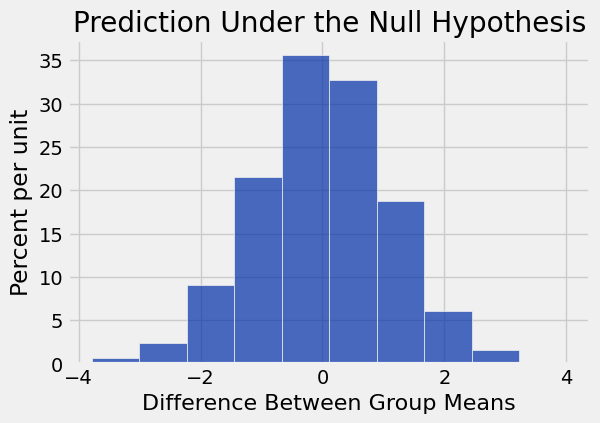

In [ ]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

분포가 대략 0을 중심으로 어떻게 집중되어 있는지 주목하세요. 이는 의미가 있습니다. 왜냐하면 귀무가설 하에서 두 그룹은 대략 같은 평균을 가져야 하기 때문입니다. 따라서 그룹 평균 간의 차이는 0 근처여야 합니다.

원래 표본의 관측된 차이는 약 $-9.27$ 온스인데, 이는 히스토그램의 가로축 척도에조차 나타나지 않습니다. 통계량의 관측값과 귀무가설 하에서의 통계량의 예측된 행동은 일관되지 않습니다.

검정의 결론은 데이터가 귀무가설보다 대립가설을 지지한다는 것입니다. 이는 흡연하는 산모에게서 태어난 아기의 평균 출생 체중이 비흡연자에게서 태어난 아기의 평균 출생 체중보다 낮다는 가설을 지지합니다.

경험적 p-값을 계산하려면, 통계량의 낮은 값이 대립가설을 지지한다는 것을 기억하세요.

In [ ]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

경험적 p-값은 0입니다. 이는 5,000개의 순열된 표본 중 어느 것도 -9.27 이하의 차이를 초래하지 않았다는 것을 의미합니다. 이것은 근사값일 뿐입니다. 그 범위의 차이를 얻을 정확한 확률은 0이 아닙니다. 하지만 우리의 시뮬레이션에 따르면 무시할 수 있을 정도로 작으므로, 귀무가설을 기각할 수 있습니다.

## Another 순열검정
흡연자와 비흡연자의 연령과 같은 다른 속성을 비교하기 위해 같은 방법을 사용할 수 있습니다. 두 그룹의 연령 히스토그램은 표본에서 흡연한 산모들이 더 젊은 경향이 있음을 보여줍니다.

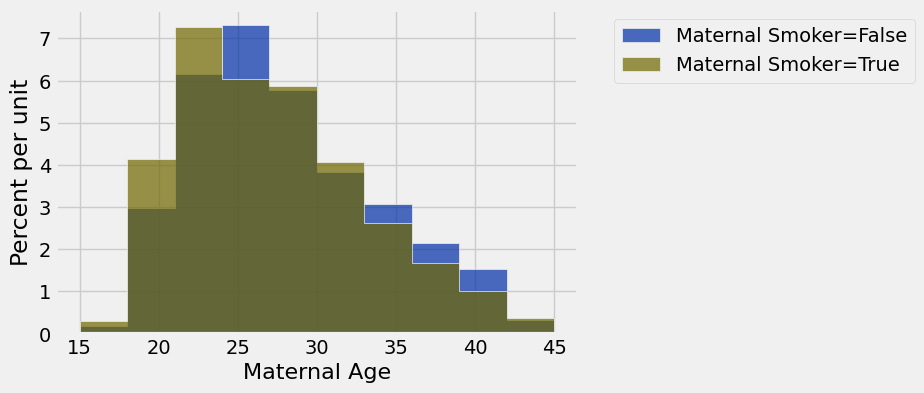

In [ ]:
smoking_and_age = births.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')

평균 연령 간의 관측된 차이는 약 $-0.8$년입니다.

출생 체중을 비교한 코드를 다시 작성하여 이제 흡연자와 비흡연자의 연령을 비교하도록 하겠습니다.

In [ ]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select('Maternal Age', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [ ]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

차이는 흡연자의 평균 연령에서 비흡연자의 평균 연령을 뺀 값으로 계산된다는 것을 기억하세요. 음수 부호는 흡연자가 평균적으로 더 젊다는 것을 보여줍니다.

이 차이는 우연 때문인가요, 아니면 모집단의 기저 차이를 반영하는 것인가요?

이전과 같이, 이 질문에 답하기 위해 순열검정을 사용할 수 있습니다. 두 그룹의 연령 기저 분포가 동일하다면, 순열된 표본에 기반한 차이의 경험적 분포는 통계량이 우연으로 인해 어떻게 변동해야 하는지 예측할 것입니다.

모든 시뮬레이션에서와 같은 과정을 따를 것입니다. 평균 간 차이의 시뮬레이션된 값 하나를 반환하는 함수를 작성하는 것으로 시작한 다음, `for` 루프를 작성하여 그러한 값을 여러 번 시뮬레이션하고 배열에 수집할 것입니다.

In [ ]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean ages
    of smokers and non-smokers after shuffling labels"""

    # 섞인 라벨의 배열
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')

    # 연령과 섞인 라벨의 테이블
    shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)

    return difference_of_means(shuffled_table, 'Shuffled Label')

In [ ]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

관측된 차이는 귀무가설 하에서 시뮬레이션된 차이의 경험적 분포의 꼬리에 있습니다.

In [ ]:
observed_age_difference = -0.8

Observed Difference: -0.8


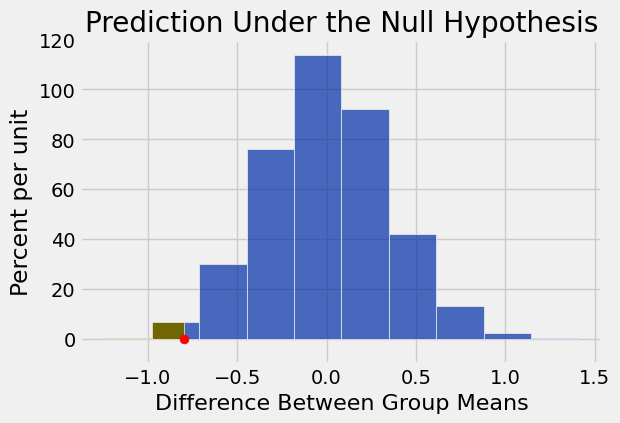

In [ ]:
Table().with_column(
    'Difference Between Group Means', age_differences).hist(
    right_end = observed_age_difference)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

다시 한번, 시뮬레이션된 차이의 경험적 분포는 대략 0을 중심으로 집중되어 있습니다. 왜냐하면 시뮬레이션이 두 그룹의 분포 사이에 차이가 없다는 귀무가설 하에 있기 때문입니다.

검정의 경험적 p-값은 관측된 차이 이하인 시뮬레이션된 차이의 비율입니다. 이는 차이의 낮은 값이 흡연자가 평균적으로 더 젊었다는 대립가설을 지지하기 때문입니다.

In [ ]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0102

경험적 p-값은 약 1%이므로 결과는 통계적으로 유의합니다. 검정은 흡연자가 평균적으로 더 젊었다는 가설을 지지합니다.